In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

## Load Data

In [2]:
# Load Gene Information DataFrame

gene_df = pd.read_csv(  os.path.join("Genomes", "Sclav_Gene_Info.csv")   )
gene_df = gene_df[ gene_df["gene_biotype"] == "protein_coding" ]
gene_df.shape

(6786, 13)

In [3]:
# Select Genes to Draw Heatmap
DEGs = joblib.load( os.path.join("data", "DEGs_pval0.005.joblib") )
heatmap_deg = set()

for updown in ["Up", "Down"]:
    
    C1_deg = [DEGs[updown][f"C1-{time}"].index.to_list() for time in ["08h", "14h", "36h", "72h"]]
    C1_deg = set([item for sublist in C1_deg for item in sublist])
    
    OR_deg = [DEGs[updown][f"OR-{time}"].index.to_list() for time in ["08h", "14h", "36h", "72h"]]
    OR_deg = set([item for sublist in OR_deg for item in sublist])
    
    NL_deg = [DEGs[updown][f"NL-{time}"].index.to_list() for time in ["08h", "14h", "36h", "72h"]]
    NL_deg = set([item for sublist in NL_deg for item in sublist])
    
    heatmap_deg.update(    C1_deg & OR_deg & NL_deg     )
    
len(heatmap_deg)

1525

In [4]:
# Define a function to filter out deleted genes
def filter_out_deleted_genes(genes_set, gene_df):
    # Genes from the plasmid that are outside the non-deleted region (804919 ~ 1407036) are removed
    deleted_genes = gene_df.query(
        "(contig == 'plasmid') and (start < 804919 or end > 1407036)"
    )["locus_tag"].to_list()
    return genes_set - set(deleted_genes)

heatmap_deg = filter_out_deleted_genes(heatmap_deg, gene_df)

#### Draw Heatmap

In [5]:
foldchange_df = pd.DataFrame()

# Get FoldChange Data
foldchange_dict = joblib.load("data/FoldChange_Dict.joblib")
for key, df in foldchange_dict.items():
    foldchange_df[key] = df['log2FoldChange']
del foldchange_dict

# Select FoldChange Data for Heatmap Genes
foldchange_df = foldchange_df.loc[list(heatmap_deg)]
foldchange_df

,C1-08h,C1-14h,C1-36h,C1-72h,OR-08h,OR-14h,OR-36h,OR-72h,NL-08h,NL-14h,NL-36h,NL-72h
Geneid,,,,,,,,,,,,
CRV15_RS36795,-3.993591,0.602913,-2.055694,2.560551,-3.036675,1.453863,-2.598875,1.386058,-3.290379,0.743267,-2.847792,-1.672866
CRV15_RS05230,1.618823,0.100904,1.725279,2.702155,2.516106,0.481381,0.942534,1.710833,1.617603,0.818885,0.770860,2.109815
CRV15_RS16770,-2.003397,-0.537056,-0.111071,-0.503691,-1.507986,-0.407650,-0.003695,0.280259,-1.319538,-0.117422,0.037537,0.610722
CRV15_RS25395,1.539213,1.495757,3.581590,0.944461,0.554087,1.227549,2.685004,-0.086186,1.910419,1.251569,2.672985,1.838739
CRV15_RS10125,0.936731,0.914472,-1.505715,-0.534874,0.172257,0.682118,-1.492292,-0.132419,0.245082,0.742559,-1.722554,-0.844464
...,...,...,...,...,...,...,...,...,...,...,...,...
CRV15_RS24270,0.445834,-0.114544,-1.500202,-1.690126,0.922665,1.210652,-1.422090,-1.543365,0.178064,-0.103718,-2.327124,-2.249211
CRV15_RS35915,2.198015,-0.177638,-2.091559,-0.099207,2.122408,-0.380938,-0.757086,3.099561,1.927593,-0.287093,-1.360226,2.294776
CRV15_RS13390,0.933032,1.401149,-0.825009,1.399769,1.067473,1.366262,-1.518128,4.745075,0.463712,2.198244,-1.086516,4.891411


In [6]:
# Separate Plasmid and Chromosome Genes
deg_gene_df = gene_df.query("`locus_tag` in @foldchange_df.index")

plasmid_df = foldchange_df.loc[deg_gene_df[deg_gene_df["contig"] == "plasmid"].locus_tag]
chromosome_df = foldchange_df.loc[deg_gene_df[deg_gene_df["contig"] == "chromosome"].locus_tag]

print("plasmid_df.shape:", plasmid_df.shape, "chromosome_df.shape:", chromosome_df.shape)

plasmid_df.shape: (156, 12) chromosome_df.shape: (1291, 12)


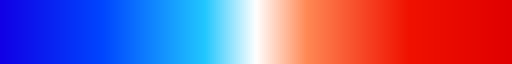

In [7]:
from matplotlib.colors import LinearSegmentedColormap
color_list = [(0, "#1100E5"), (0.2, "#0046FF"), (0.4, "#21C7FE"),
              (0.5, "#FFFFFF"), 
              (0.6, "#FF8854"), (0.8, "#F01100"), (1.0, "#E00000")]
my_cmap = LinearSegmentedColormap.from_list("my_cmap", color_list)
my_cmap

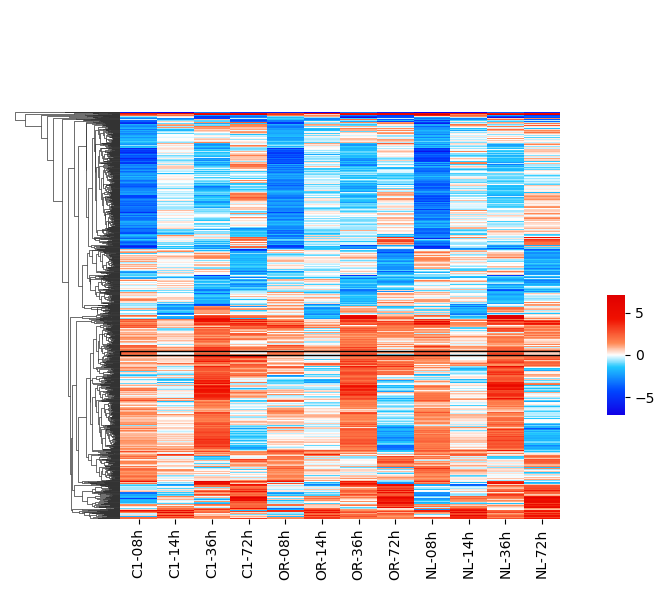

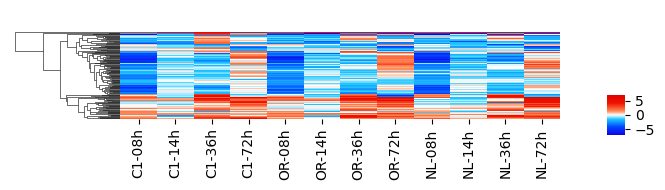

In [8]:
def DrawFoldchangeClustermap(data: pd.DataFrame, figsize):
    ax = sns.clustermap(data, cmap=my_cmap, col_cluster=False,
                        figsize = figsize, vmax = 7.1, vmin = -7.1,
                        yticklabels = False)
    
    row_dendrogram = ax.dendrogram_row.dendrogram
    yticklabels = [data.index[i] for i in row_dendrogram['leaves']]
    
    ax.ax_heatmap.set_ylabel("")    
    ax.ax_cbar.set_position((1.02, .3, .03, .2))
    
    from matplotlib.patches import Rectangle
    # Draw a rectangle on the heatmap
    rect = Rectangle((0, 760), height=12, width=data.shape[1], linewidth=1, edgecolor='black', facecolor='none')
    ax.ax_heatmap.add_patch(rect)
    
    return yticklabels
    
ytick_chromosome = DrawFoldchangeClustermap(chromosome_df, figsize=(6, 6))
ytick_plasmid = DrawFoldchangeClustermap(plasmid_df, figsize=(6, 2))

In [9]:
# tmp_df = pd.read_excel("Sclav_Gene_Info_Integrated.xlsx")
# tmp_df.set_index("locus_tag", inplace=True)
# with pd.ExcelWriter("ClusteredGenes.xlsx") as writer:
#     tmp_df.loc[ytick_chromosome].to_excel(writer, sheet_name="chromosome")
#     tmp_df.loc[ytick_plasmid].to_excel(writer, sheet_name="plasmid")

#### Figure B

In [10]:
text = """CRV15_RS01190	naringenin	Known
CRV15_RS10590	naringenin	Unknown
CRV15_RS18460	naringenin	Unknown
CRV15_RS01185	naringenin	Known
CRV15_RS37330	naringenin	Known
CRV15_RS26790	naringenin	Unknown
CRV15_RS01180	naringenin	Known
CRV15_RS01200	naringenin	Known
CRV15_RS24230	arginine Biosynthesis	Known
CRV15_RS07550	arginine Biosynthesis	Known
CRV15_RS24235	arginine Biosynthesis	Known
CRV15_RS24240	arginine Biosynthesis	Known
CRV15_RS24225	arginine Biosynthesis	Known
CRV15_RS24245	arginine Biosynthesis	Known
CRV15_RS24215	arginine Biosynthesis	Known
CRV15_RS24220	arginine Biosynthesis	Known
CRV15_RS10350	Ribosome	Known
CRV15_RS05770	Ribosome	Unknown
CRV15_RS10120	Ribosome	Known
CRV15_RS10155	Ribosome	Known
CRV15_RS22680	Ribosome	Unknown
CRV15_RS14095	Ribosome	Unknown
CRV15_RS17470	Ribosome	Unknown
CRV15_RS05780	Ribosome	Known
CRV15_RS10345	Ribosome	Known
CRV15_RS10320	Ribosome	Unknown
CRV15_RS24110	Ribosome	Known
CRV15_RS19620	Ribosome	Known
CRV15_RS10270	Ribosome	Known
CRV15_RS10280	Ribosome	Known
CRV15_RS10150	Ribosome	Known
CRV15_RS10275	Ribosome	Known
CRV15_RS10305	Ribosome	Unknown
CRV15_RS10310	Ribosome	Known
CRV15_RS10285	Ribosome	Known
CRV15_RS10290	Ribosome	Known
CRV15_RS10245	Ribosome	Known
CRV15_RS10145	Ribosome	Unknown
CRV15_RS10255	Ribosome	Known
CRV15_RS10225	Ribosome	Known
CRV15_RS10235	Ribosome	Known
CRV15_RS10240	Ribosome	Known
CRV15_RS10230	Ribosome	Known
CRV15_RS10250	Ribosome	Known
CRV15_RS10195	Ribosome	Known
CRV15_RS10190	Ribosome	Known
CRV15_RS10205	Ribosome	Known
CRV15_RS10220	Ribosome	Known
CRV15_RS24115	Ribosome	Known
CRV15_RS10115	Ribosome	Known
CRV15_RS10210	Ribosome	Known
CRV15_RS07275	Ribosome	Unknown
CRV15_RS19625	Ribosome	Known
CRV15_RS08605	Quorum Sensing	Known
CRV15_RS08615	Quorum Sensing	Known
CRV15_RS08595	Quorum Sensing	Known
CRV15_RS08600	Quorum Sensing	Known
CRV15_RS06550	Quorum Sensing	Known
CRV15_RS18885	Quorum Sensing	Unknown
CRV15_RS07900	Quorum Sensing	Unknown
CRV15_RS06530	Quorum Sensing	Known
CRV15_RS06535	Quorum Sensing	Known
CRV15_RS06540	Quorum Sensing	Known
CRV15_RS07475	cephamycin C BGC	Known
CRV15_RS06375	cephamycin C BGC	Unknown
CRV15_RS07510	cephamycin C BGC	Known
CRV15_RS07520	cephamycin C BGC	Known
CRV15_RS07485	cephamycin C BGC	Known
CRV15_RS07490	cephamycin C BGC	Known
CRV15_RS07480	cephamycin C BGC	Known
CRV15_RS07515	cephamycin C BGC	Known
CRV15_RS07565	Clavulanic Acid BGC	Known
CRV15_RS07570	Clavulanic Acid BGC	Known
CRV15_RS07610	Clavulanic Acid BGC	Known
CRV15_RS07575	Clavulanic Acid BGC	Known
CRV15_RS07585	Clavulanic Acid BGC	Known
CRV15_RS07590	Clavulanic Acid BGC	Known
CRV15_RS07595	Clavulanic Acid BGC	Known
CRV15_RS07540	Clavulanic Acid BGC	Known
CRV15_RS07535	Clavulanic Acid BGC	Known
CRV15_RS07545	Clavulanic Acid BGC	Known
CRV15_RS13870	Clavulanic Acid BGC	Known
CRV15_RS07600	Clavulanic Acid BGC	Known
CRV15_RS07605	Clavulanic Acid BGC	Known
CRV15_RS33265	Clavulanic Acid BGC (plasmid)	Known
CRV15_RS33250	Clavulanic Acid BGC (plasmid)	Known
CRV15_RS33285	Clavulanic Acid BGC (plasmid)	Known
CRV15_RS33255	Clavulanic Acid BGC (plasmid)	Known
CRV15_RS33270	Clavulanic Acid BGC (plasmid)	Known
CRV15_RS33275	Clavulanic Acid BGC (plasmid)	Known
"""

# Split the text into lines and then into columns
lines = text.strip().split('\n')
data = [line.split('\t') for line in lines]
heatmap_target_genes = pd.DataFrame(data, columns=['Gene', 'Process', 'Known'])

In [11]:
# Map the 'Known' column to binary values (1 for Known, 0 for Unknown)
heatmap_target_genes['Known'] = heatmap_target_genes['Known'].map({'Known': 1, 'Unknown': 0})

# Create the Known/Unknown DataFrame with 'Gene' as the index
known_unknown_data = heatmap_target_genes.set_index('Gene')[['Known']]

target_heatmap_data = foldchange_df.loc[heatmap_target_genes['Gene']]

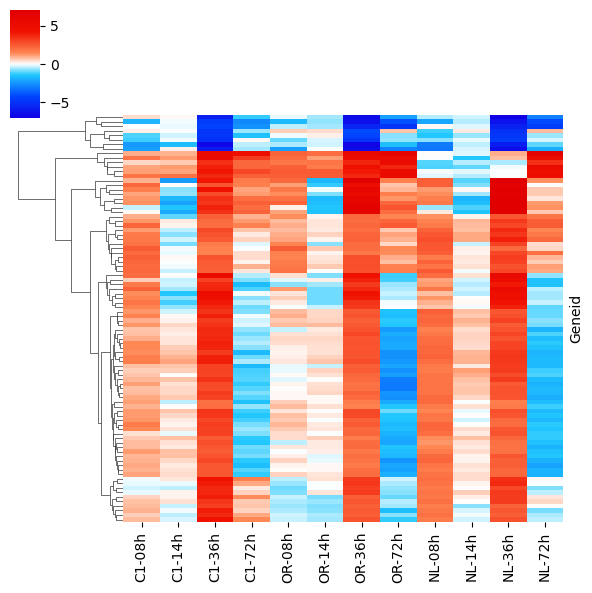

In [12]:
ax = sns.clustermap(target_heatmap_data, cmap=my_cmap, col_cluster=False, figsize=(6, 6),
                    vmax=7.1, vmin=-7.1, yticklabels=False)

row_dendrogram = ax.dendrogram_row.dendrogram
yticklabels = [target_heatmap_data.index[i] for i in row_dendrogram['leaves']]

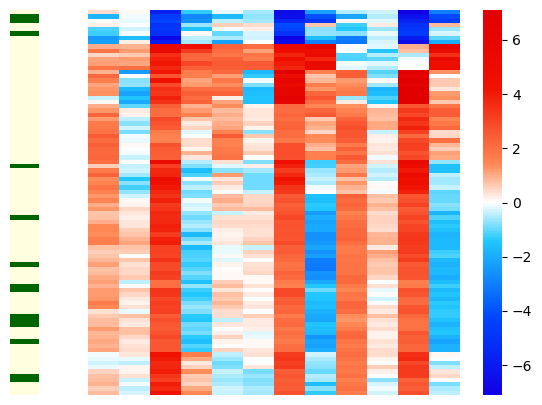

In [13]:
# Reorder the main heatmap data and the Known/Unknown data based on the clustering order
target_heatmap_data_ordered = target_heatmap_data.loc[yticklabels]
known_unknown_data_ordered = known_unknown_data.loc[yticklabels]

# ---------------------------
# Part 4: Plot the Two Heatmaps Side by Side Using plt.subplots
# ---------------------------
# Create a custom colormap for the Known/Unknown heatmap
cmap_known = mcolors.ListedColormap(['darkgreen', 'lightyellow'])

# Create subplots with two axes (width ratios 1:16)
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 16]}, figsize=(7, 5))

# Plot the Known/Unknown heatmap on the left subplot
sns.heatmap(known_unknown_data_ordered, cmap=cmap_known, cbar=False, ax=ax1,
            yticklabels=False, xticklabels=False)
ax1.set_ylabel('')  # Remove the y-axis label

# Plot the main heatmap on the right subplot using the same row order
sns.heatmap(target_heatmap_data_ordered, cmap=my_cmap, ax=ax2,
            vmax=7.1, vmin=-7.1, yticklabels=False, xticklabels=False)
ax2.set_ylabel('')  # Remove the y-axis label

plt.show()